# Lab 7 - Compare ResNet with Plain CNN

In this exercise, we will build a ResNet and a plain CNN model using Keras and then compare their performance. We expect that ResNet should outperform the CNN with the same network depth. 

## Step 1 - Import Packages
First, we need to install packages we need for this project. 

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, Flatten, Dense, \
  BatchNormalization, concatenate, Input, Activation, AveragePooling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

## Step 2 - Load and Prepare the CIFAR10 Dataset
Next, we need to download and prepare the dataset for our experiment. For this exercise, we will use the CIFAR10 dataset. We load the data with the `cifar10` function from Keras into training and test split. Then, we normalize its values to between 0 and 1. Lastly, we convert the labels to one-hot encoded representations. 

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [ ]:
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Step 3 - Define ResNet and Plain CNN
Here, you will define the ResNet and Plain CNN using Keras. 
You can refer to this [link](https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba) for some guidance on building ResNet. 

In [ ]:
# Define ResNet model
def ReluBatchNorm(x):
    # TODO: Implement a function that performs the following operations:
    # 1. Apply ReLU activation function
    # 2. Apply Batch Normalization

    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    return x

def ResNetBlock(input_tensor, num_filters, kernel_size=3, downsample=False):
    # TODO: Implement a function that performs the following operations:
    # 1. Apply Batch Normalization and ReLU activation function
    # 2. Apply 2D Convolutional layer with num_filters filters, kernel_size, and padding='same'
    # 3. Apply Batch Normalization and ReLU activation function
    # 4. Apply 2D Convolutional layer with num_filters filters, kernel_size, and padding='same'
    # 5. If downsample is True, apply 2D Convolutional layer with num_filters filters, kernel_size=1, and strides=2
    # 6. Add the input_tensor to the output of the second Conv2D layer
    # 7. Apply Batch Normalization and ReLU activation function

    x = Conv2D(num_filters, kernel_size=kernel_size, strides=(1 if not downsample else 2),
               padding='same')(input_tensor)
    x = ReluBatchNorm(x)
    x = Conv2D(num_filters, kernel_size=kernel_size, strides=1,
               padding='same')(x)
    
    if downsample:
        input_tensor = Conv2D(num_filters, kernel_size=1, 
                              strides=2, padding='same')(input_tensor)

    x = Add()([input_tensor, x])
    x = ReluBatchNorm(x)
    return x

def ResNet(input_shape, num_classes):
    # TODO: Implement a function that builds a ResNet model with the following architecture:
    # 1. Apply Batch Normalization
    # 2. Apply 2D Convolutional layer with 64 filters, kernel_size=3, and padding='same'
    # 3. Apply Batch Normalization and ReLU activation function
    # 4. Apply 2 ResNetBlock with 64 filters
    # 5. Apply 5 ResNetBlocks with 128 filters
    # 6. Apply 5 ResNetBlocks with 256 filters
    # 7. Apply 2 ResNetBlocks with 512 filters
    # 8. Apply AveragePooling2D with pool_size=4
    # 9. Apply Flatten layer
    # 10. Apply Dense layer with num_classes units and softmax activation function

    input_tensor = Input(shape=input_shape)
    x = BatchNormalization()(input_tensor)
    x = Conv2D(64, kernel_size=3, padding='same')(x)
    x = ReluBatchNorm(x)
    num_filters = 64
    num_blocks_list = [2, 5, 5, 2]
    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            x = ResNetBlock(x, num_filters, downsample=(j == 0 and i != 0))
        num_filters *= 2

    x = AveragePooling2D(pool_size=4)(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=x)
    return model

In [ ]:
def CNN(input_shape, num_classes):
    #TODO: Implement a function that builds a CNN model with the following architecture:
    # 1. Apply Batch Normalization
    # 2. Apply 2D Convolutional layer with 64 filters, kernel_size=3, and padding='same'
    # 3. Apply ReLU activation function
    # 4. Apply 2 2D Convolutional layer with 64 filters, kernel_size=3, and padding='same'
    # 5. Apply ReLU activation function and Batch Normalization
    # 6. Apply 5 2D Convolutional layer with 128 filters, kernel_size=3, and padding='same'
    # 7. Apply ReLU activation function and Batch Normalization
    # 8. Apply 5 2D Convolutional layer with 256 filters, kernel_size=3, and padding='same'
    # 9. Apply ReLU activation function and Batch Normalization
    # 10. Apply 2 2D Convolutional layer with 512 filters, kernel_size=3, and padding='same'
    # 11. Apply ReLU activation function and Batch Normalization
    # 12. Apply AveragePooling2D with pool_size=4
    # 13. Apply Flatten layer
    # 14. Apply Dense layer with num_classes units and softmax activation function

    input_tensor = Input(shape=input_shape)
    num_filters = 64
    
    x = BatchNormalization()(input_tensor)
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = ReluBatchNorm(x)

    num_blocks_list = [2, 5, 5, 2]
    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            downsample = (j==0 and i!=0)
            x = Conv2D(num_filters, kernel_size=3, strides=(1 if not downsample else 2),
                          padding='same')(x)
            x = ReluBatchNorm(x)
        num_filters *= 2

    x = AveragePooling2D(pool_size=4)(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=x)

    return model

## Step 4 - Train and Evaluate
Lastly, we will compile the models you defined and then train and evaluate them.

In [ ]:
input_shape = x_train.shape[1:]

In [ ]:
resnet = ResNet(input_shape, num_classes)
cnn = CNN(input_shape, num_classes)

In [ ]:
optimizer = "adam"
loss = 'categorical_crossentropy'
metrics = ['accuracy']

In [ ]:
# Compile models
resnet.compile(optimizer=optimizer, loss=loss, metrics=metrics)
cnn.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
model_checkpoint_resnet = ModelCheckpoint('best_model_resnet.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='auto')

In [ ]:
# Train models
epochs = 50
batch_size = 64

In [ ]:
resnet_history = resnet.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[early_stopping, model_checkpoint_resnet])

Epoch 1/50
782/782 [==============================] - ETA: 0s - loss: 1.5272 - accuracy: 0.4537
Epoch 1: val_loss improved from inf to 7.18449, saving model to best_model_resnet.h5
782/782 [==============================] - 103s 101ms/step - loss: 1.5272 - accuracy: 0.4537 - val_loss: 7.1845 - val_accuracy: 0.4622
Epoch 2/50
781/782 [============================>.] - ETA: 0s - loss: 1.0712 - accuracy: 0.6233
Epoch 2: val_loss improved from 7.18449 to 1.05979, saving model to best_model_resnet.h5
782/782 [==============================] - 78s 100ms/step - loss: 1.0711 - accuracy: 0.6234 - val_loss: 1.0598 - val_accuracy: 0.6470
Epoch 3/50
781/782 [============================>.] - ETA: 0s - loss: 0.8519 - accuracy: 0.7071
Epoch 3: val_loss did not improve from 1.05979
782/782 [==============================] - 77s 98ms/step - loss: 0.8519 - accuracy: 0.7071 - val_loss: 1.0797 - val_accuracy: 0.6710
Epoch 4/50
781/782 [============================>.] - ETA: 0s - loss: 0.7005 - accuracy: 

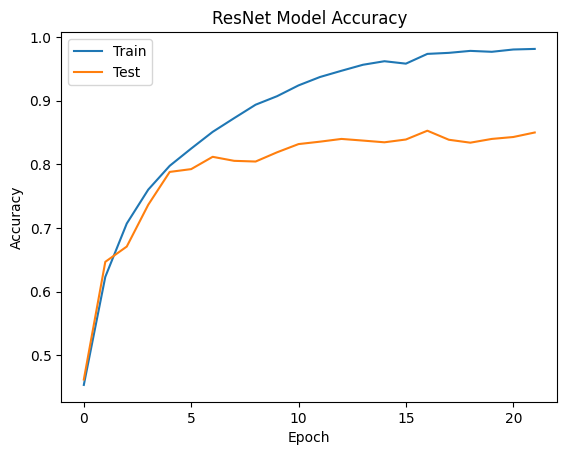

In [ ]:
# Plot training history
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('ResNet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
model_checkpoint_cnn = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='auto')

In [ ]:
cnn_history = cnn.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[early_stopping, model_checkpoint_cnn])

Epoch 1/50
782/782 [==============================] - ETA: 0s - loss: 1.3874 - accuracy: 0.5014
Epoch 1: val_loss improved from inf to 1.87366, saving model to best_model_cnn.h5
782/782 [==============================] - 56s 52ms/step - loss: 1.3874 - accuracy: 0.5014 - val_loss: 1.8737 - val_accuracy: 0.5027
Epoch 2/50
782/782 [==============================] - ETA: 0s - loss: 0.8606 - accuracy: 0.6968
Epoch 2: val_loss improved from 1.87366 to 0.96289, saving model to best_model_cnn.h5
782/782 [==============================] - 39s 50ms/step - loss: 0.8606 - accuracy: 0.6968 - val_loss: 0.9629 - val_accuracy: 0.6989
Epoch 3/50
781/782 [============================>.] - ETA: 0s - loss: 0.6556 - accuracy: 0.7726
Epoch 3: val_loss improved from 0.96289 to 0.79319, saving model to best_model_cnn.h5
782/782 [==============================] - 39s 50ms/step - loss: 0.6555 - accuracy: 0.7726 - val_loss: 0.7932 - val_accuracy: 0.7374
Epoch 4/50
782/782 [==============================] - ETA: 

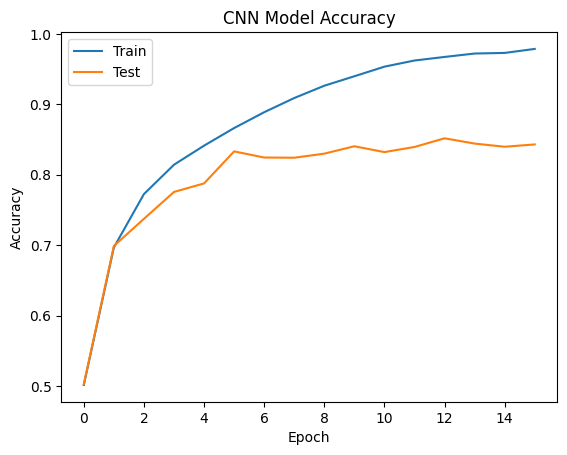

In [ ]:
# Plot training history
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
resnet_score = resnet.evaluate(x_test, y_test, verbose=0)
print('ResNet Test Loss:', resnet_score[0])
print('ResNet Test Accuracy:', resnet_score[1])

In [ ]:
cnn_score = cnn.evaluate(x_test, y_test, verbose=0)
print('CNN Test Loss:', cnn_score[0])
print('CNN Test Accuracy:', cnn_score[1])